# Description

It summarizes the GLS results on eMERGE.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 309
N_LVS = 987

In [3]:
INPUT_DIR = conf.RESULTS["GLS"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

INPUT_PATTERN = "emerge/**/*.tsv.gz"
display(INPUT_PATTERN)

PosixPath('/opt/data/results/gls')

'emerge/**/*.tsv.gz'

In [4]:
PVALUE_COLUMN = "pvalue"

In [5]:
OUTPUT_DIR = conf.RESULTS["GLS"]
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/results/gls')

# Load data

## Phenotype info

In [6]:
pheno_info = pd.read_csv(
    conf.EMERGE["DESC_FILE_WITH_SAMPLE_SIZE"],
    sep="\t",
    dtype={"phecode": str},
    usecols=["phecode", "phenotype", "category"],
)

In [7]:
pheno_info.shape

(309, 3)

In [8]:
pheno_info = pheno_info.rename(
    columns={
        "phecode": "short_code",
        "phenotype": "phenotype_desc",
    }
)

In [9]:
pheno_info["short_code"] = pheno_info["short_code"].apply(lambda x: f"EUR_{x}")

In [10]:
pheno_info.head()

,short_code,phenotype_desc,category
0,EUR_008,Intestinal infection,infectious diseases
1,EUR_008.5,Bacterial enteritis,infectious diseases
2,EUR_008.52,Intestinal infection due to C. difficile,infectious diseases
3,EUR_038,Septicemia,infectious diseases
4,EUR_038.3,Bacteremia,infectious diseases


In [11]:
assert pheno_info["short_code"].is_unique

In [12]:
pheno_code_to_desc_map = pheno_info.set_index("short_code")["phenotype_desc"].to_dict()

## GLS results

### Get files list

In [13]:
INPUT_FILES = list(INPUT_DIR.glob(INPUT_PATTERN))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/emerge/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-EUR_440.2.tsv.gz'),
 PosixPath('/opt/data/results/gls/emerge/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-EUR_433.21.tsv.gz'),
 PosixPath('/opt/data/results/gls/emerge/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-EUR_706.tsv.gz'),
 PosixPath('/opt/data/results/gls/emerge/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-EUR_740.1.tsv.gz'),
 PosixPath('/opt/data/results/gls/emerge/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-EUR_250.24.tsv.gz')]

In [14]:
_tmp = len(INPUT_FILES)
display(_tmp)
assert _tmp == N_PHENOTYPES

309

### Read results

In [15]:
INPUT_FILES[0].name.split("gls_phenoplier-")[1].split(".tsv.gz")[0]

'EUR_440.2'

In [16]:
dfs = [
    pd.read_csv(f, sep="\t", usecols=["lv", "pvalue_onesided"]).assign(
        phenotype=f.name.split("gls_phenoplier-")[1].split(".tsv.gz")[0]
    )
    for f in INPUT_FILES
]

In [17]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

309

In [18]:
dfs = pd.concat(dfs, axis=0, ignore_index=True).rename(
    columns={"pvalue_onesided": "pvalue"}
)

In [19]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(304983, 3)

In [20]:
# add phenotype description
dfs = dfs.assign(
    phenotype_desc=dfs["phenotype"].apply(lambda x: pheno_code_to_desc_map[x])
)
dfs = dfs[["phenotype", "phenotype_desc", "lv", "pvalue"]]

In [21]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue
0,EUR_440.2,Atherosclerosis of the extremities,LV472,1.033637e-07
1,EUR_440.2,Atherosclerosis of the extremities,LV182,3.710244e-07
2,EUR_440.2,Atherosclerosis of the extremities,LV348,7.379936e-07
3,EUR_440.2,Atherosclerosis of the extremities,LV504,1.534424e-06
4,EUR_440.2,Atherosclerosis of the extremities,LV445,2.912525e-06


In [22]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

### FDR adjust

In [23]:
adj_pval = multipletests(dfs[PVALUE_COLUMN], alpha=0.05, method="fdr_bh")
dfs = dfs.assign(fdr=adj_pval[1])

In [24]:
dfs.shape

(304983, 5)

In [25]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,EUR_440.2,Atherosclerosis of the extremities,LV472,1.033637e-07,0.000658
1,EUR_440.2,Atherosclerosis of the extremities,LV182,3.710244e-07,0.001432
2,EUR_440.2,Atherosclerosis of the extremities,LV348,7.379936e-07,0.002558
3,EUR_440.2,Atherosclerosis of the extremities,LV504,1.534424e-06,0.004500
4,EUR_440.2,Atherosclerosis of the extremities,LV445,2.912525e-06,0.007402


# QQ-plot

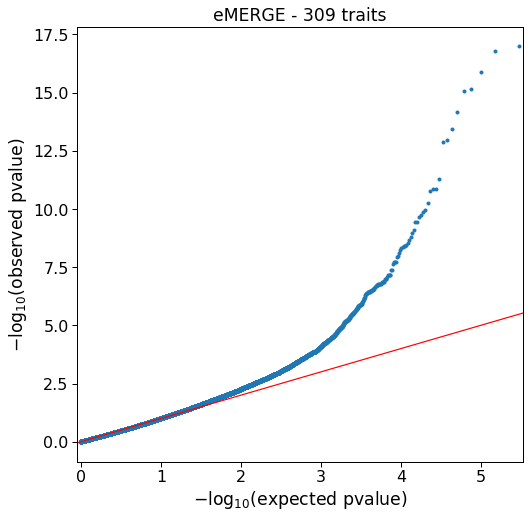

In [26]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs["pvalue"])
    ax.set_title(f"eMERGE - {N_PHENOTYPES} traits")

# Top hits

In [27]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs.sort_values("fdr").drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,phenotype_desc,lv,pvalue,fdr
10858,Coagulation defects,LV490,1.661877e-17,2.534221e-12
10857,Coagulation defects,LV149,1.035420e-17,2.534221e-12
10859,Coagulation defects,LV57,1.303465e-16,1.325116e-11
246750,Gout,LV770,7.002364e-16,5.021953e-11
10860,Coagulation defects,LV347,8.233169e-16,5.021953e-11
185556,Gout and other crystal arthropathies,LV770,6.647582e-15,3.378999e-10
83895,Type 2 diabetes,LV959,3.597225e-14,1.567275e-09
118440,Diabetes mellitus,LV959,1.070984e-13,4.082900e-09
92778,Hypercholesterolemia,LV246,1.297435e-13,4.396619e-09
175686,Other venous embolism and thrombosis,LV490,5.160790e-12,1.573953e-07


## LV246

In [28]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs[dfs["lv"] == "LV246"].sort_values("fdr").drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,phenotype_desc,lv,pvalue,fdr
92778,Hypercholesterolemia,LV246,1.297435e-13,4.396619e-09
263529,Hyperlipidemia,LV246,1.385444e-11,3.570114e-07
195426,Disorders of lipoid metabolism,LV246,1.613478e-11,3.785258e-07
254654,Memory loss,LV246,9.477824e-06,1.795786e-02


# Optimize data types

In [29]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,EUR_440.2,Atherosclerosis of the extremities,LV472,1.033637e-07,0.000658
1,EUR_440.2,Atherosclerosis of the extremities,LV182,3.710244e-07,0.001432
2,EUR_440.2,Atherosclerosis of the extremities,LV348,7.379936e-07,0.002558
3,EUR_440.2,Atherosclerosis of the extremities,LV504,1.534424e-06,0.004500
4,EUR_440.2,Atherosclerosis of the extremities,LV445,2.912525e-06,0.007402


In [30]:
dfs.memory_usage()

Index                 128
phenotype         2439864
phenotype_desc    2439864
lv                2439864
pvalue            2439864
fdr               2439864
dtype: int64

In [31]:
dfs["phenotype"] = dfs["phenotype"].astype("category")
dfs["phenotype_desc"] = dfs["phenotype_desc"].astype("category")
dfs["lv"] = dfs["lv"].astype("category")

In [32]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,EUR_440.2,Atherosclerosis of the extremities,LV472,1.033637e-07,0.000658
1,EUR_440.2,Atherosclerosis of the extremities,LV182,3.710244e-07,0.001432
2,EUR_440.2,Atherosclerosis of the extremities,LV348,7.379936e-07,0.002558
3,EUR_440.2,Atherosclerosis of the extremities,LV504,1.534424e-06,0.004500
4,EUR_440.2,Atherosclerosis of the extremities,LV445,2.912525e-06,0.007402


In [33]:
dfs.memory_usage()

Index                 128
phenotype          622678
phenotype_desc     622678
lv                 658822
pvalue            2439864
fdr               2439864
dtype: int64

# Save

In [34]:
output_file = OUTPUT_DIR / "gls-summary-emerge.pkl.gz"
display(output_file)

PosixPath('/opt/data/results/gls/gls-summary-emerge.pkl.gz')

In [35]:
dfs.to_pickle(output_file)